In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import sys
from glob import glob
import math
from scipy import ndimage
import skimage as ski
from skimage.feature import hog


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn import preprocessing

%matplotlib inline

train_folder='train/'
test_folder='test/'

WIDTH = 256
HEIGHT = 256

In [2]:
image_list = glob('./50_categories/*/*.jpg')
cat_list = glob('./50_categories/*')
categories = []
cat_class = {}
class_num = 0
for cat in cat_list:
    cat_name = cat.split("\\")[1]
    if not cat in categories:
        categories.append(cat_name)
        cat_class[cat_name] = class_num
        class_num = class_num + 1


In [3]:
if not (os.path.exists(train_folder) and os.path.exists(test_folder) ) :
    os.makedirs(train_folder)
    os.makedirs(test_folder)
    for im in image_list:
        # 20% test data
        in_train = random.random();
        #resize and save in different folder
        im_file = im.split("\\")[2]
        im_cat = im.split("\\")[1]
        im_class = cat_class[im_file.split("_")[0]] 
        if in_train < 0.8 :
            im_dest_file = train_folder + im_file
            with open(train_folder+"train.txt", "a") as f:
                f.write(im_file+"\t"+str(im_class)+"\n")
        else:
            im_dest_file = test_folder + im_file
            with open(test_folder+"test.txt", "a") as f:
                f.write(im_file+"\t"+str(im_class)+"\n")
        img = cv2.imread(im)
        img_res = cv2.resize(img,(WIDTH, HEIGHT), interpolation = cv2.INTER_AREA)
        cv2.imwrite(im_dest_file, img_res)
else:
    print("Data already exist!")

Data already exist!


In [4]:
def extract_features(img):
    """Extract a vector of features from an image. The feature vector is
    flat, but has the following components:

        1) Mean of R, G, and B channels
        2) Covariance between R, G, and B channels
        3) Summary statistics of image entropy

    Parameters
    ----------
    img : numpy.ndarray
        The image to extract features from.

    Returns
    -------
    feature_vec : numpy.ndarray
        One-dimensional numpy array of features

    """
    RGB = img.reshape((-1, 3)).T

    # mean of each channel
    mean = np.mean(RGB, axis=1)
    # median of each channel
    median = np.median(RGB, axis=1)
    # covariance between channels
    cov = np.cov(RGB).ravel()
    # (normalized) entropy of the grayscale image
    entropy = ski.filters.rank.entropy(
        np.mean(img, axis=-1).astype('uint16'),
        ski.morphology.disk(5))
    entropy = entropy / float(img.size)
    entropy_sum = np.sum(entropy)
    entropy_mean = np.mean(entropy)
    entropy_var = np.var(entropy)
    
    #hog :http://scikit-image.org/docs/dev/auto_examples/plot_hog.html
    img_grey = ski.color.rgb2gray(img)
    fd, hog_image = hog(img_grey, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
    # concatenate all the features together
    feature_vec = np.concatenate(
        [mean, median, cov, [entropy_sum, entropy_mean, entropy_var], fd])

    return feature_vec

1920
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


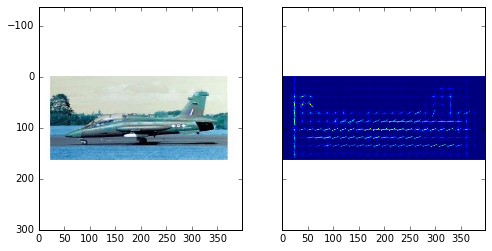

In [5]:
##
# HoG 
img = cv2.imread(image_list[0])
img_grey = ski.color.rgb2gray(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.imshow(img)

fd, hog_image = hog(img_grey, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
ax2.imshow(hog_image)

print(len(fd))
print(hog_image)
fv =  extract_features(img)

In [ ]:
##
# Need to implement in parallel


##
#train
train_file = train_folder + 'train.txt'
test_file = test_folder + 'test.txt'
y = np.array([])
x = np.ndarray([])
n_train = 0
with open(train_file) as f:
    for line in f:
        train_img_file = line.split('\t')[0]
        class_num = line.split('\t')[1]
        img = cv2.imread(train_folder+train_img_file)
        fv = extract_features(img)
        y = np.append(y,[int(class_num)])
        if n_train ==0:
            x = fv
        else:
            x = np.vstack([x, fv])
        n_train = n_train + 1

yt = np.array([])
xt = np.ndarray([])
n_test = 0
with open(test_file) as f:
    for line in f:
        test_img_file = line.split('\t')[0]
        class_num = line.split('\t')[1]
        img = cv2.imread(test_folder+test_img_file)
        fv = extract_features(img)
        yt = np.append(y,[int(class_num)])
        if n_test ==0:
            xt = fv
        else:
            xt = np.vstack([xt, fv])
        n_test = n_test + 1

print(x)
print(y)

In [ ]:
##
#random forest not 
rf = RandomForestClassifier(n_estimators=i, n_jobs=2,oob_score=True)
rf.fit(X, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]-1):
    if (importances[indices[f]])>0.01:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

oob_error = 1 - rf.oob_score_

yts=rf.predict(XT)
ets= 1- sum(yts==yt)/len(yt)
F1=metrics.f1_score(yts,yt)
print('%d %5.3f %5.3f %5.3f' % (i,oob_error,ets,F1))
    
